# 8.4 변이형 오토인코더를 사용한 이미지 생성

## 8.4.1 이미지의 잠재 공간에서 샘플링하기


### 이미지 생성 분야의 2가지 주요 모델

- 변이형 오토인코더 (Variational AutoEncoders, VAE)
- 적대적 생성 네트워크 (Generative Adversarial Network, GAN)

### 이미지 생성의 핵심 아이디어
- 각 포인트가 실제와 같은 이미지로 매핑될 수 있는 저차원 잠재공간(latent space)의 표현을 만드는 것


### 이미지 생성 방식

- 잠재 공간에서 한 포인트를 샘플링하고 이를 생성자 또는 디코더에 입력으로 넣어주면 출력으로 이미지를 생성함


- 여기서 잠재 공간의 한 포인트를 입력으로 받아 이미지를 출력하는 모듈을 생성자 또는 디코더라고 부름
    - GAN의 경우 : 생성자(generator)
    - VAE의 경우 : 디코더(decoder)
    

<img src="./images/generating_images.png" alt="generating_images" align="left"/>

### VAE와 GAN의 특징

#### 변이형 오토인코더 (Variational AutoEncoders, VAE)
- VAE는 구조적인 잠재 공간을 학습하는데 뛰어남
- 잠재 공간의 특정 방향은 데이터에서 의미있는 변화의 방향을 인코딩 함

#### 적대적 생성 네트워크 (Generative Adversarial Network, GAN)
- GAN은 매우 실제같은 이미지를 만들어냄
- 잠재 공간이 구조적이지 않고 연속성이 없을 수 있음


## 8.4.2 이미지 변형을 위한 개념 벡터

### 개념 벡터 (concept vector)

- **개념벡터란 이미지 공간에서 독립적으로 변화가 일어나는 모든 차원을 말함**


- 잠재 공간에서 공간의 어떤 방향(개념벡터)은 원본 데이터의 변화를 인코딩한 축일 수 있음(임베딩 공간에서와 유사)
    - 예를 들면 얼굴 이미지의 잠재 공간에서 특정 축은 얼굴 이미지의 웃음에 관련된 벡터일 수 있음


- 따라서 개념 벡터를 찾아내면 다음의 과정을 통해 변형된 이미지를 얻을 수 있음
    1. 이미지를 잠재공간에 투영
    2. 투영후 얻은 표현을 찾아낸 벡터의 방향으로 이동
    3. 다시 이미지 공간으로 디코딩

## 8.4.3 변이형 오토인코더

### 오토인코더 (AutoEncoder)
- 오토인코더는 입력을 저차원 잠재 공간으로 인코딩한 후 디코딩하여 복원하는 네트워크를 말함

- 입력 이미지와 동일한 이미지를 타깃 데이터로 사용하여 훈련함

- 전통적인 오토인코더는 여러가지 제약을 가해 입력 데이터를 압축한 후 복원하거나 입력 데이터에 노이즈를 추가한 후 복원하도록 학습을 시킴


<img src="./images/autoencoder.png" alt="autoencoder" align="left" />

### 변이형 오토인코더 (Variational AutoEncoders, VAE)

- VAE는 오토인코더에 통계기법을 추가하여 연속적이고 구조적인 잠재 공간을 학습하도록 만든 것
    - 딥러닝과 베이지안 추론의 아이디어를 혼합한 오토인코더의 최신 버전이라고 볼 수 있음
    - 개념벡터를 사용한 이미지 변형에 적절함
    

### VAE의 동작 방식
1. 이미지를 통계 분포의 파라미터(평균과 분산)로 변환
    - 입력 이미지가 통계적 과정을 통해서 생성되었다고 가정하여 인코딩과 디코딩하는 동안 무작위성이 필요하다는 것을 의미
    
    
2. 변환된 평균과 분산을 사용해 이 분포에서 무작위로 하나의 샘플을 추출함
    - 이러한 무작위한 과정은 안정성을 향상하고 잠재공간 어디서든 의미있는 표현을 인코딩하도록 만들어줌
    - 잠재 공간에서 샘플링한 모든 포인트는 유효한 출력으로 디코딩 될 수 있다는 것을 의미
    

3. 이 샘플을 디코딩하여 원본 입력으로 복원


<img src="./images/vae.png" alt="vae" align="left" />

### VAE의 구현

케라스의 VAE 구현을 간단히 나타내면 다음과 같음


1. 입력을 평균과 분산 파라미터로 인코딩
    - `z_mean, z_log_var = encoder(input_img)`


2. 무작위로 선택한 작은 epsilon 값을 사용해 잠재 공간의 포인트를 샘플링
    - `z = z_mean + exp(0.5 * z_log_var) * epsilon`


3. z를 이미지로 디코딩
    - `reconstructed_img = decoder(z)`
    

4. 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델 객체를 만듦
    - `model = Model(input_img, reconstructed_img)`


- 참고) 분산 파라미터를 분산의 로그값으로 사용한 이유
    - 인코더 네트워크는 음수를 출력할 수 있기 때문에 분산의 로그값을 출력하도록 학습

### VAE의 손실 함수

VAE의 파라미터는 다음의 2개의 손실함수로 훈련됨


1. 재구성 손실(reconstruction loss)
    - 디코딩 된 샘플이 원본 입력과 동일하도록 만드는 손실
    - 크로스엔트로피 손실을 사용
    
    
2. 규제 손실(regularization loss)
    - 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 손실
    - 쿨백 라이블러 발산(Kullback-Leibler divergence, KLD)을 사용
    - 규제 손실을 잠재 변수 손실(latent loss)라고도 부름
    
    
- 참고) 쿨백 라이블러 발산(Kullback-Leibler divergence, KLD)
    - 쿨백 라이블러 발산은 두 확률분포의 차이를 계산하는 데에 사용하는 함수
    - 어떤 이상적인 분포에 대해, 그 분포를 근사하는 다른 분포를 사용해 샘플링을 한다면 발생할 수 있는 정보 엔트로피 차이를 계산함

In [1]:
# 인코더 네트워크
# 이미지를 잠재 공간상 확률 분포 파라미터로 매핑

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense

import numpy as np

# mnist 이미지를 사용하므로 크기는 (28, 28, 1)
img_shape = (28, 28, 1)

# 잠재 공간의 차원 : 2D 평면
latent_dim = 2

batch_size = 16

input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
# 이 층에서만 stride의 영향 때문에 이미지의 h, w가 h/2, w/2로 줄어듦
# (padding='same' 때문에 기본적으로 이미지는 resizing되지 않음)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# 입력 이미지가 2개의 파라미터로 인코딩 됨
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [2]:
# 잠재 공간 샘플링 함수
# 잠재 공간의 포인트 z를 생성

from tensorflow.keras.layers import Lambda


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# Lambda 클래스는 함수 객체를 케라스의 층으로 만들어줌(파이썬의 lambda와 다름)
z = Lambda(sampling)([z_mean, z_log_var])

In [3]:
# 디코더 네트워크
# 벡터 z를 다시 원본 이미지와 같은 크기의 특성맵으로 바꾼 후 합성곱 층을 사용해 최종 출력 이미지 생성

from tensorflow.keras.layers import Reshape, Conv2DTranspose

# z를 입력으로 받음
decoder_input = Input(K.int_shape(z)[1:])

# shape_before_flattening의 크기로 복원

# 1. 입력 z를 shape_before_flattening의 전체 원소 수가 되도록 변환(업샘플링)
x = Dense(np.prod(shape_before_flattening[1:]),
          activation='relu')(decoder_input)
# 2. shape_before_flattening와 같은 크기로 복원
x = Reshape(shape_before_flattening[1:])(x)

# 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩
# Conv2DTranspose는 deconvolution(역합성곱)이라고도 하며 컨볼루션 연산을 반대로 수행하는 연산
# 인코더에서 stride를 통해 줄어든 이미지 크기를 다시 키워줌
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)

x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# 이 decoder는 잠재공간에서 샘플링한 후 디코딩할 때 사용할 디코더
decoder = Model(decoder_input, x)

# 이 z_decoded는 전체 VAE 네트워크를 학습할 때 사용할 디코딩된 값
z_decoded = decoder(z)

In [4]:
# VAE의 손실을 계산하기 위해 직접 만든 층

class CustomVariationalLayer(tf.keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # 재구성 손실
        recon_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        # 규제 손실
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        return K.mean(recon_loss + kl_loss)
    
    # 사용하지는 않지만 call()이 있는 층으로 구현하였음
    # 독자적인 층을 구현하려면 call()외에도 build(), compute_output_shape() 등을 구현해야 함
    # 자세한 내용은 케라스 문서 참고
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

    
y = CustomVariationalLayer()([input_img, z_decoded])

In [5]:
from tensorflow.keras.optimizers import RMSprop

# 모델 구성

vae = Model(input_img, y)

# 층에서 손실을 다루기 때문에 compile()에서 손실을 지정하지 않음
# experimental_run_tf_function=False가 없으면 fit에서 에러남
vae.compile(optimizer=RMSprop(), loss=None, experimental_run_tf_function=False)

vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
# 모델 훈련

from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


# loss를 지정하지 않았기 때문에 fit()에서 target(y_train)를 전달하지 않음
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s 434us/sample - loss: 0.2141 - val_loss: 0.1989
Epoch 2/10
60000/60000 [==============================] - 25s 412us/sample - loss: 0.1959 - val_loss: 0.1921
Epoch 3/10
60000/60000 [==============================] - 24s 399us/sample - loss: 0.1916 - val_loss: 0.1929
Epoch 4/10
60000/60000 [==============================] - 25s 418us/sample - loss: 0.1893 - val_loss: 0.1885
Epoch 5/10
60000/60000 [==============================] - 25s 417us/sample - loss: 0.1876 - val_loss: 0.1875
Epoch 6/10
60000/60000 [==============================] - 25s 417us/sample - loss: 0.1865 - val_loss: 0.1861
Epoch 7/10
60000/60000 [==============================] - 25s 419us/sample - loss: 0.1854 - val_loss: 0.1860
Epoch 8/10
60000/60000 [==============================] - 25s 416us/sample - loss: 0.1846 - val_loss: 0.1841
Epoch 9/10
60000/60000 [==============================] - 25s 421us/sample - l

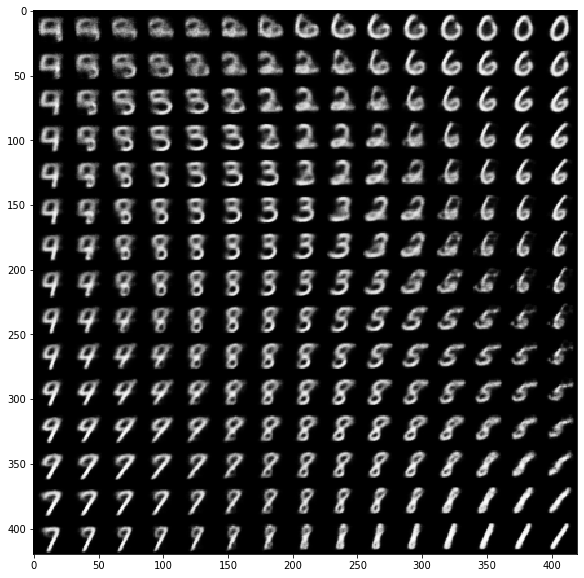

In [7]:
# 디코더 네트워크로 잠재 공간(2D)의 포인트 그리드를 샘플링하여 이미지로 변환

import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))


# scipy의 ppf() : 정규분포의 백분위수를 전달하면 해당 포인트 값을 반환하는 함수
# scipy의 cpf() : 정규분포의 포인트 값을 전달하면 해당 백분위수를 반환하는 함수

# 일정한 간격으로 떨어진 잠재 변수 z를 만듦
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        
        # np.tile()은 입력 값을 반복하여 늘리는 역할을 함
        # xi, yi를 batch_size만큼 반복한 후 차원을 (batch_size, 2)로 바꿈
        # batch_size만큼 한번에 주입해서 CPU/GPU 성능을 효과적으로 사용하려고 이렇게 함
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        # 배치를 숫자 이미지로 디코딩
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        # 배치의 첫번째 숫자 크기를 28x28x1에서 28x28로 변환
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i+1) * digit_size,
               j * digit_size : (j+1) * digit_size] = digit
        
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

- 샘플링된 숫자의 그리드는 다른 숫자 클래스 사이에서 완벽하게 연속된 분포를 보여줌
- 잠재 공간의 한 경로를 따라서 한 숫자가 다른 숫자로 자연스럽게 바뀌는 것을 볼 수 있음
    - 예를 들어 '6으로 가는 방향' 또는 '9로 가는 방향' 등
    

#### 참고) CelebA(Large-scale Celeb Faces Attiributes) 데이터셋

- 유명인사 사진 20만개 데이터셋
- 이미지 생성 더 공부할 때, 이 데이터셋으로 해보기
    - 개념벡터의 실험에 MNIST보다 더 좋음